In [1]:
import numpy as np
import pickle

In [2]:
def segment_iou(target_segment, candidate_segments):
    """
    Compute the temporal intersection over union between a
    target segment and all the test segments.
    Parameters
    ----------
    target_segment : 1d array
        Temporal target segment containing [starting, ending] times.
        
    candidate_segments : 2d array
        Temporal candidate segments containing N x [starting, ending] times.
    
    Outputs
    -------
    tiou : 1d array
        Temporal intersection over union score of the N's candidate segments.
    """
    tt1 = np.maximum(target_segment[0], candidate_segments[:, 0])
    tt2 = np.minimum(target_segment[1], candidate_segments[:, 1])
    # Intersection including Non-negative overlap score.
    segments_intersection = (tt2 - tt1).clip(0)
    # Segment union.
    segments_union = (candidate_segments[:, 1] - candidate_segments[:, 0]) \
      + (target_segment[1] - target_segment[0]) - segments_intersection
    # Compute overlap as the ratio of the intersection
    # over union of two segments.
    tIoU = segments_intersection.astype(float) / segments_union
    return tIoU


In [3]:
def derive_recall_rate(ground_truth_segments, candidate_segments, tIoU_thresh):
    """
    Compute the recall rate of the target video
    Parameters
    ----------
    ground_truth_segments : 2d array
        Temporal target segment containing M x [starting, ending] times.
        
    candidate_segments : 2d array
        Temporal candidate segments containing N x [starting, ending] times.
    
    Outputs
    -------
    recall_rate
    """
    ground_truth_num = ground_truth_segments.shape[0]
    recalled_count = 0.0
    for ground_truth_segment in ground_truth_segments:
        tIoU = segment_iou(ground_truth_segment, candidate_segments)
        sorted_tIoU = np.sort(tIoU)
        highest_detection_score = sorted_tIoU[-1]
        if highest_detection_score >= tIoU_thresh:
            recalled_count += 1
            
    recall_rate = recalled_count / ground_truth_num
    return recall_rate, recalled_count, ground_truth_num
        

In [13]:
candidate_segments = np.array([[2, 5], [16, 17]])
ground_truth_segments = np.array([[1, 10], [15, 20]])

tIoU_thresh = 0.3
recall_rate, recalled_count, ground_truth_num = derive_recall_rate(ground_truth_segments, candidate_segments, tIoU_thresh)
print(recall_rate)
print(recalled_count)
print(ground_truth_num)


0.5
1.0
2


In [20]:
def read_predicted_proposal():
    with open('../data/outputs/predicted_proposal.pkl', 'rb') as f:
        results = pickle.load(f)
        return results

def derive_overall_recall_rate(tIoU_thresh, results, print_info=False):
    if print_info: print('----------------------------------------------')
    total_recalled_count = 0.0
    total_ground_truth_num = 0.0
    for key in results.keys():
        ground_truth_segments = np.array(results[key]['ground_truth'])
        candidate_segments = np.array(results[key]['predict'])
        recall_rate, recalled_count, ground_truth_num = derive_recall_rate(ground_truth_segments, candidate_segments, tIoU_thresh)

        if print_info: 
            print(key + '\t- local recall rate: ' + str(recall_rate) + '\t(' + str(recalled_count) + '/' + str(ground_truth_num) + ')')

        total_recalled_count += recalled_count
        total_ground_truth_num += ground_truth_num

    total_recall_rate = total_recalled_count / total_ground_truth_num
    if print_info: 
        print
        print('Total recall rate: ' + str(total_recall_rate) + '\t(' + str(total_recalled_count) + '/' + str(total_ground_truth_num) + ')')
        print('tIoU_thresh: ' + str(tIoU_thresh))
    
    return total_recall_rate
    
results = read_predicted_proposal()
tIoU_thresh_values = np.linspace(0.0, 1.0, num=20)

total_recall_rates =[]
for tIoU_thresh in tIoU_thresh_values:
    total_recall_rate = derive_overall_recall_rate(tIoU_thresh, results)
    total_recall_rates.append(total_recall_rate)

print(tIoU_thresh_values, total_recall_rates)


[ 0.          0.05263158  0.10526316  0.15789474  0.21052632  0.26315789
  0.31578947  0.36842105  0.42105263  0.47368421  0.52631579  0.57894737
  0.63157895  0.68421053  0.73684211  0.78947368  0.84210526  0.89473684
  0.94736842  1.        ] [1.0, 0.8421052631578947, 0.6842105263157895, 0.631578947368421, 0.5263157894736842, 0.5263157894736842, 0.3684210526315789, 0.3157894736842105, 0.2631578947368421, 0.21052631578947367, 0.21052631578947367, 0.21052631578947367, 0.21052631578947367, 0.21052631578947367, 0.15789473684210525, 0.10526315789473684, 0.10526315789473684, 0.0, 0.0, 0.0]


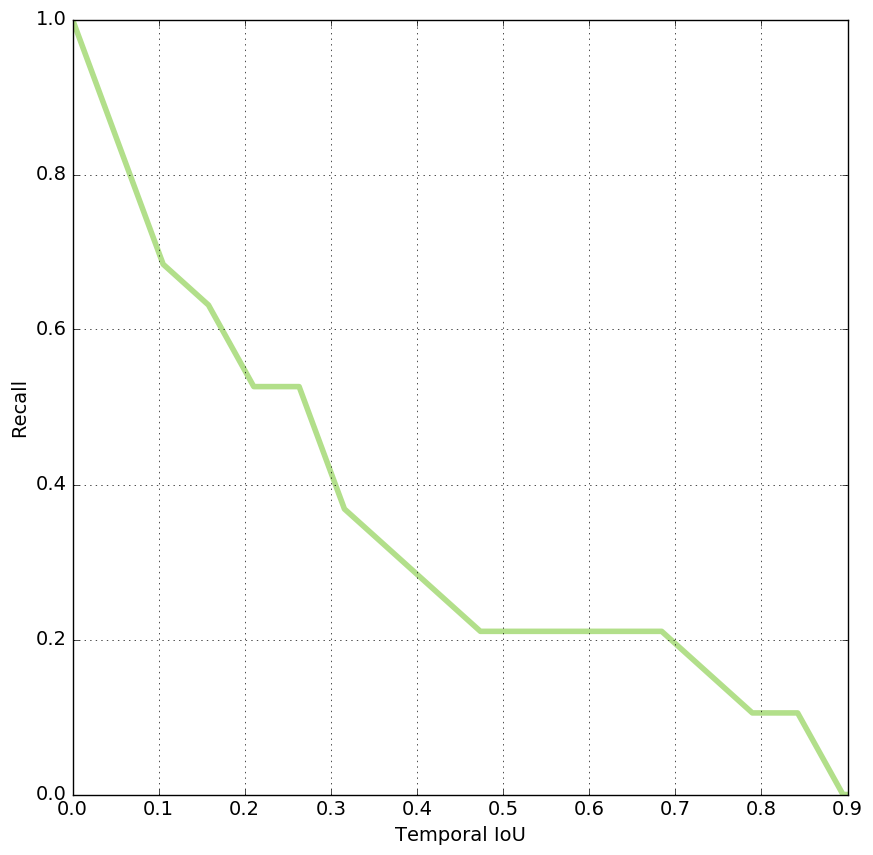

In [23]:
import matplotlib.pyplot as plt

fn_size = 14
plt.figure(num=None, figsize=(10, 10))
plt.plot(tIoU_thresh_values, total_recall_rates, linewidth=4, color=np.array([178,223,138])/255.0)
plt.xlabel('Temporal IoU', fontsize=fn_size)
plt.ylabel('Recall', fontsize=fn_size)
plt.grid(b=True, which="both")
plt.setp(plt.axes().get_xticklabels(), fontsize=fn_size)
plt.setp(plt.axes().get_yticklabels(), fontsize=fn_size)
plt.xlim([0, 0.9])
plt.show()

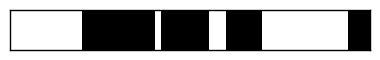

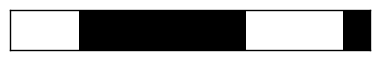

In [71]:
gt = np.array(results['4.avi']['ground_truth'])
pt = np.array(results['4.avi']['predict'])
gt_bar = np.zeros(gt[-1][-1])
pt_bar = np.zeros(pt[-1][-1])
for s, e in gt:
    gt_bar[s:e] = 1
for s, e in pt:
    pt_bar[s:e] = 1

axprops = dict(xticks=[], yticks=[])
barprops = dict(aspect='auto', cmap=plt.cm.binary, interpolation='nearest')

fig = plt.figure()
x = np.where(gt_bar == 1, 1.0, 0.0)
x.shape = 1, len(x)
ax = fig.add_axes([0.3, 0.1, 0.6, 0.1], **axprops)
ax.imshow(x, **barprops)

fig = plt.figure()
x = np.where(pt_bar == 1, 1.0, 0.0)
x.shape = 1, len(x)
ax = fig.add_axes([0.3, 0.1, 0.6, 0.1], **axprops)
ax.imshow(x, **barprops)

plt.show()